# Semantic Segmentation of Images using Tensorflow
In this notebook we will perform so aclled semantic segmentation of images using U-net architecture as the design of the network. Semantic segmentation consists of training a CNN to automatically segment images to pretrained classes.

In [1]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, concatenate, Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, AveragePooling2D, Flatten, Conv2DTranspose, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import categorical_crossentropy, MeanSquaredError
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import glob

We'll start with reading the test data. In this case each image consists of two parts the left part being the image and the right being the segmented, ground truth, image. In this case the images are three channel, RGB, which means that we do not automatically know the number of classes in the image. The ground truth are in this case RGB images had they been binary images, one for each class, the number of output channels in the model would simply be changed to match the number of channels, classes, on the binary ground truth.

In [2]:
#data from https://www.kaggle.com/dansbecker/cityscapes-image-pairs
current_folder = os.getcwd()
train_path = current_folder + '/data/cityscapes_data/train'
test_path = current_folder + '/data/cityscapes_data/val'

In [3]:
train_data = [] 
train_label = []
width = 128
height  = 128
count = 0

for image in glob.glob(train_path + '/' + '*.jpg'):
    img = cv.imread(train_path + '/' + str(count+1) + '.jpg')
    data = img[:,:256]
    label = img[:,256:]
    train_data.append(cv.resize(data, (width,height), interpolation=cv.INTER_CUBIC)) #Resize the image and save them
    train_label.append(cv.resize(label, (width,height), interpolation=cv.INTER_CUBIC))
    count += 1 
    
train_data = np.array(train_data).astype('float32') / 255.0 #Convert to float and normalize data
train_label  = np.array(train_label).astype('float32') / 255.0 

For this project we will use the U-net architecture but modified as to having 3 inout channels instead of 1. The model consists of 2 main building blocks, downsampling, and upsampling. The downsampling block consists of two convolutions followed by a maxpooling layer and then performing dropout as regularization. The upsampling on the otherhand consists of a transpose layer, the upsampling, followed by a concatenation with the corresponding downsampling block i.e. first upsampling block concatenates the transposed result with the last downsampling blocks second convolution this is then followed by dropout and two convolutional layers. The final output is then, in this case, a 3 channel image. To train the network we will use mean square error as the loss function since the images are not binary nor will each channel represent a class. Had we only work with segmenting images into two classes then binary crossentropy would have been more suitable and for several binary channels categorical crossentropy would most likely be better.

In [4]:
def U_Net():
    input_size = (128,128,3)
    input_dim = Input(input_size)
    
    conv1 = Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_dim)
    conv1 = Conv2D(16, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    
    conv2 = Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(32, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    
    conv3 = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(64, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    
    conv4 = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(128, kernel_size = (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    pool4  = Dropout(0.5)(pool4)
    
    convm = Conv2D(256, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(256, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(128, (3, 3), activation="relu", padding="same")(uconv4)
    
    deconv3 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(64, (3, 3), activation="relu", padding="same")(uconv3)
    
    deconv2 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(32, (3, 3), activation="relu", padding="same")(uconv2)
    
    deconv1 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(16, (3, 3), activation="relu", padding="same")(uconv1)

    output = Conv2D(3, kernel_size = (1,1), padding = 'same', activation = 'sigmoid')(uconv1)
    
    model = Model(inputs = input_dim, outputs = output)         
    model.compile(loss = 'MSE', #'categorical_crossentropy',
                  optimizer = Adam(lr=0.001),
                  metrics = ['accuracy'])

    return model
   

We split the training data into training and validation data

In [5]:
x_train, x_validation, y_train, y_validation = train_test_split(train_data, train_label, test_size = 0.3, random_state = 7)

In [6]:
model = U_Net()

We set up the callback function to save the best trained model, another reqularization techniqque to help decrease overfitting.

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True, monitor='val_loss')
]

In [8]:
trained_model = model.fit(x_train, y_train, batch_size = 32, epochs = 50, callbacks = callbacks,\
                    validation_data = (x_validation, y_validation))

Train on 2082 samples, validate on 893 samples
Epoch 1/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.0468 - accuracy: 0.3752
Epoch 00001: val_loss improved from inf to 0.03752, saving model to best_model.h5
2082/2082 [==============================] - 254s 122ms/sample - loss: 0.0468 - accuracy: 0.3752 - val_loss: 0.0375 - val_accuracy: 0.3077
Epoch 2/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.0326 - accuracy: 0.4081
Epoch 00002: val_loss improved from 0.03752 to 0.02782, saving model to best_model.h5
2082/2082 [==============================] - 288s 138ms/sample - loss: 0.0326 - accuracy: 0.4082 - val_loss: 0.0278 - val_accuracy: 0.5101
Epoch 3/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.5635
Epoch 00003: val_loss improved from 0.02782 to 0.02460, saving model to best_model.h5
2082/2082 [==============================] - 274s 132ms/sample - loss: 0.0263 - accuracy: 0.5634 - val_loss: 0.0246 - val_accur

2080/2082 [============================>.] - ETA: 0s - loss: 0.0140 - accuracy: 0.6279
Epoch 00027: val_loss improved from 0.01370 to 0.01360, saving model to best_model.h5
2082/2082 [==============================] - 262s 126ms/sample - loss: 0.0140 - accuracy: 0.6280 - val_loss: 0.0136 - val_accuracy: 0.6627
Epoch 28/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.0136 - accuracy: 0.6352
Epoch 00028: val_loss did not improve from 0.01360
2082/2082 [==============================] - 264s 127ms/sample - loss: 0.0136 - accuracy: 0.6352 - val_loss: 0.0137 - val_accuracy: 0.6646
Epoch 29/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.0135 - accuracy: 0.6374
Epoch 00029: val_loss improved from 0.01360 to 0.01338, saving model to best_model.h5
2082/2082 [==============================] - 265s 127ms/sample - loss: 0.0135 - accuracy: 0.6373 - val_loss: 0.0134 - val_accuracy: 0.6549
Epoch 30/50
2080/2082 [============================>.] - ETA: 0s - loss: 0.

We now load the test data in the same way as the training data

In [9]:
test_data = [] 
test_label = []
count = 0

for image in glob.glob(test_path + '/' + '*.jpg'):
    img = cv.imread(test_path + '/' + str(count+1) + '.jpg')
    data = img[:,:256]
    label = img[:,256:]
    test_data.append(cv.resize(data, (width,height), interpolation=cv.INTER_CUBIC))
    test_label.append(cv.resize(label, (width,height), interpolation=cv.INTER_CUBIC))
    count += 1 
    
test_data = np.array(test_data).astype('float32') / 255.0 #Convert to float and normalize data
test_label  = np.array(test_label).astype('float32') / 255.0 

Next we use our trained model to try and segment the training images into different objects.

In [10]:
preds = np.zeros((len(test_data),128*128,3))

for i in range(len(test_data)):
    pred = model.predict(test_data[i][ np.newaxis, ...])
    preds[i] = pred.reshape(128*128,3)

Finally we'll look at the result. In this case the, "best", metric to meassure how accurate the model is is the mean square error had we instead worked with binary ground truth images then something like dice score or jaccard index would have been more suitable, but neither works with non binary labels.

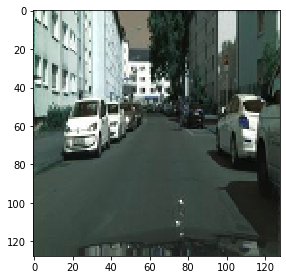

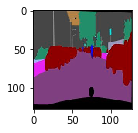

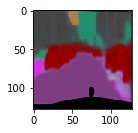

In [11]:
plt.figure(1, figsize = (15,15))
plt.subplot(131)
plt.imshow(test_data[1])
plt.show()
plt.subplot(131)
plt.imshow(test_label[1])
plt.show()
plt.subplot(131)
plt.imshow(preds[1].reshape(128,128,3))
plt.show()

First we'll look at the input image

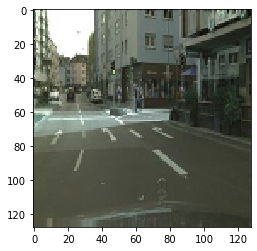

In [12]:
plt.imshow(test_data[215])

Next we'll look at the target segmentation 

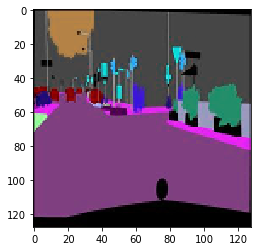

In [13]:
plt.imshow(test_label[215])

Finally we'll look at the resulting segmentation

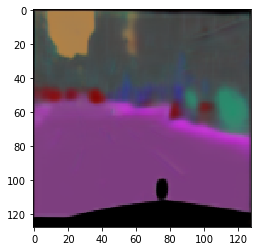

In [14]:
plt.imshow(preds[215].reshape(128,128,3))

So as we can see the U-net architecture after 50 epochs manages to segment the car and road well. It did also capture the general layout in regards to what is buildings and sky and more importantly it did also segment teh other vehicles fairly well. One thing which it basically completely failed to segment was traffic lights and signs. 